<a href="https://colab.research.google.com/github/mohamed-habib-jaberi/Deep-Learning/blob/main/%F0%9F%8D%A9%F0%9F%A7%A0_DeepDish_Vision_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project : 🍩🧠 DeepDish Vision

In the previous notebook (transfer learning part 3: scaling up) we built Food Vision mini: a transfer learning model with only 10% of the data.

But you might be wondering, what would happen if we used all the data?

Well, that's what we're going to find out in this notebook!

We're going to be building DeepDish Vision, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images

**we're going to learn about two methods to significantly improve the speed of our model training:**

1.   Prefetching
2.   Mixed precision training




**What we're going to cover**

*   Using TensorFlow Datasets to download and explore data
*   Creating preprocessing function for our data
*   Batching & preparing datasets for modelling (making our datasets run fast)
*   Creating modelling callbacks
*   Setting up mixed precision training
*   Building a feature extraction model
*   Fine-tuning the feature extraction model

In [21]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-40e59d80-0097-1d98-afb2-43d06be583d9)


In [22]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


**Creating helper functions**

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [23]:
!wget https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/refs/heads/main/Computer%20Vision%20and%20CNN%20in%20TensorFlow/helper_functions.py

--2025-10-23 15:48:46--  https://raw.githubusercontent.com/mohamed-habib-jaberi/Deep-Learning/refs/heads/main/Computer%20Vision%20and%20CNN%20in%20TensorFlow/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10245 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0.001s  

2025-10-23 15:48:46 (17.8 MB/s) - ‘helper_functions.py.1’ saved [10245/10245]



In [24]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

**Use TensorFlow Datasets to Download Data**

https://www.tensorflow.org/datasets/overview


Why use TensorFlow Datasets?

*   Load data already in Tensors
*   Practice on well established datasets
*   Experiment with differet data loading techniques (like we're going to use in this notebook)
*   Experiment with new TensorFlow features quickly (such as mixed precision training)

In [25]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the list_builders() method.

After doing so, we can check to see if the one we're after ("food101") is present.

In [26]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")


'food101' in TensorFlow Datasets: True


To get access to the Food101 dataset from the TFDS, we can use the tfds.load() method.

In [27]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [28]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [29]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

**Exploring the Food101 data from TensorFlow Datasets**

Let's find out a few details about our dataset:

*   The shape of our input data (image tensors)
*   The datatype of our input data
*   What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
*   Do the labels match up with the class names?

To do, let's take one sample off the training data (using the .take() method) and explore it.

In [30]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [31]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 49
  Class name (str form): grilled_cheese_sandwich
        


In [32]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[239, 217, 157],
        [244, 222, 162],
        [247, 227, 168],
        ...,
        [119, 104,  73],
        [111,  95,  70],
        [105,  89,  66]],

       [[233, 212, 149],
        [239, 218, 155],
        [243, 223, 162],
        ...,
        [117, 102,  71],
        [108,  92,  67],
        [101,  85,  62]],

       [[227, 206, 139],
        [234, 213, 146],
        [238, 219, 153],
        ...,
        [117, 100,  70],
        [108,  91,  65],
        [101,  83,  59]],

       ...,

       [[ 35,   7,  19],
        [ 35,   7,  19],
        [ 36,   8,  20],
        ...,
        [198, 181, 127],
        [196, 179, 125],
        [193, 176, 122]],

       [[ 34,   6,  18],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [200, 183, 129],
        [201, 184, 130],
        [198, 181, 127]],

       [[ 33,   5,  17],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [203, 186, 13

In [33]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

**Plot an image from TensorFlow Datasets**


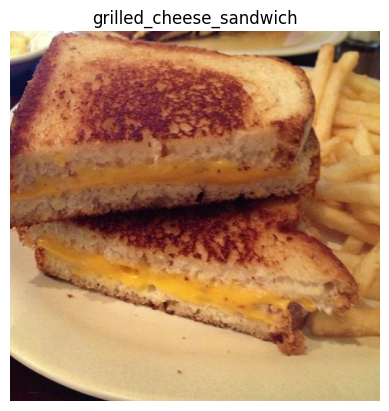

In [34]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

**Create preprocessing functions for our data**

In [35]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [37]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[239 217 157]
  [244 222 162]
  [247 227 168]
  ...
  [119 104  73]
  [111  95  70]
  [105  89  66]]

 [[233 212 149]
  [239 218 155]
  [243 223 162]
  ...
  [117 102  71]
  [108  92  67]
  [101  85  62]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[238.7704   217.41327  155.4847  ]
  [242.83673  222.83673  162.55101 ]
  [240.85713  220.20918  164.2143  ]
  ...
  [131.28564  118.28565   75.7806  ]
  [123.88257  109.81113   75.09689 ]
  [106.698746  90.698746  66.4131  ]]

 [[232.16325  212.09183  141.37755 ]
  [238.86224  219.86224  151.07654 ]
  [239.94388  221.08673  155.87245 ]
  ...
  [127.49998  112.49998   71.07145 ]
  [122.63767  106.56623   72.852   ]
  [105.83142   88.47424   63.1886  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


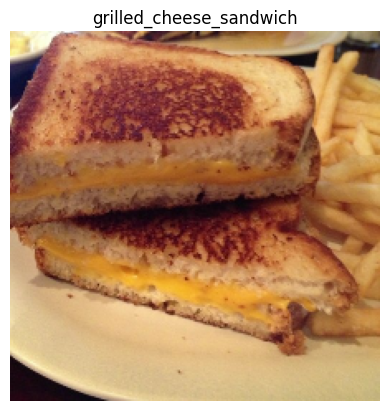

In [38]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

**Batch & prepare datasets**

Before we can model our data, we have to turn it into batches.

Because computing on batches is memory efficient.

In [39]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [40]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Create modelling callbacks**